RNN : a type of artificial neural network designed to process sequential data, where the order of elements is important, by maintaining a memory of past inputs through its hidden state.

![Screenshot 2025-06-29 203648.png](<attachment:Screenshot 2025-06-29 203648.png>)
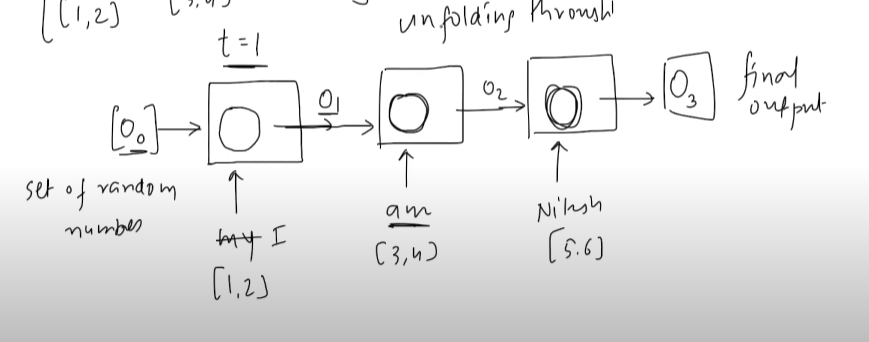

In [1]:
import pandas as pd

df = pd.read_csv('100_Unique_QA_Dataset.csv')

df.head()

,question,answer
0,What is the capital of France?,Paris
1,What is the capital of Germany?,Berlin
2,Who wrote 'To Kill a Mockingbird'?,Harper-Lee
3,What is the largest planet in our solar system?,Jupiter
4,What is the boiling point of water in Celsius?,100


In [2]:
# tokenize
def tokenize(text):
  text = text.lower()
  text = text.replace('?','')
  text = text.replace("'","")
  return text.split()

In [3]:
tokenize('What is the capital of France?')

['what', 'is', 'the', 'capital', 'of', 'france']

In [4]:
# vocab
vocab = {'<UNK>':0}

In [ ]:
def build_vocab(row):
  tokenized_question = tokenize(row['question'])
  tokenized_answer = tokenize(row['answer'])

  merged_tokens = tokenized_question + tokenized_answer

  for token in merged_tokens:

    if token not in vocab:
      vocab[token] = len(vocab)


In [6]:
df.apply(build_vocab, axis=1)

0     None
1     None
2     None
3     None
4     None
      ... 
85    None
86    None
87    None
88    None
89    None
Length: 90, dtype: object

In [7]:
len(vocab)

324

In [8]:
# Following is a function to convert text to indices based on the vocabulary created above.
# It replaces unknown tokens with the index for '<UNK>'.
def text_to_indices(text, vocab):

  indexed_text = []

  for token in tokenize(text):

    if token in vocab:
      indexed_text.append(vocab[token])
    else:
      indexed_text.append(vocab['<UNK>'])

  return indexed_text

In [9]:
text_to_indices("What is campusx", vocab)

[1, 2, 0]

In [10]:
import torch
from torch.utils.data import Dataset, DataLoader

In [11]:
class QADataset(Dataset):

  def __init__(self, df, vocab):
    self.df = df
    self.vocab = vocab

  def __len__(self):
    return self.df.shape[0]

  def __getitem__(self, index):

    numerical_question = text_to_indices(self.df.iloc[index]['question'], self.vocab)
    numerical_answer = text_to_indices(self.df.iloc[index]['answer'], self.vocab)

    return torch.tensor(numerical_question), torch.tensor(numerical_answer)

In [12]:
dataset = QADataset(df, vocab)

In [13]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [14]:
for question, answer in dataloader:
  print(question, answer[0])

tensor([[ 42, 200,   2,  14, 201, 202, 203, 204]]) tensor([205])
tensor([[ 42, 318,   2,  62,  63,   3, 319,   5, 320]]) tensor([321])
tensor([[ 42, 250, 251, 118, 252, 253]]) tensor([254])
tensor([[  1,   2,   3,  33,  34,   5, 245]]) tensor([246])
tensor([[ 1,  2,  3, 50, 51, 19,  3, 45]]) tensor([52])
tensor([[ 10,  75,   3, 296,  19, 297]]) tensor([298])
tensor([[ 42,  18, 118,   3, 186, 187]]) tensor([188])
tensor([[ 42, 137, 118,   3, 247,   5, 248]]) tensor([249])
tensor([[ 10,  11, 157, 158, 159]]) tensor([160])
tensor([[ 42,  86,  87, 241, 242,  19,  39, 243]]) tensor([244])
tensor([[ 42, 174,   2,  62,  39, 175, 176,  12, 177, 178]]) tensor([179])
tensor([[  1,   2,   3,   4,   5, 279]]) tensor([280])
tensor([[ 42, 312,   2, 313,  62,  63,   3, 314, 315]]) tensor([316])
tensor([[ 1,  2,  3, 33, 34,  5, 35]]) tensor([36])
tensor([[ 42, 137,   2, 138,  39, 175, 269]]) tensor([99])
tensor([[42, 43, 44, 45, 46, 47, 48]]) tensor([49])
tensor([[ 78,  79, 261, 151,  14, 262, 153]]) 

In [15]:
import torch.nn as nn

RNN Architecture : 

![Screenshot 2025-06-29 212147.png](<attachment:Screenshot 2025-06-29 212147.png>)
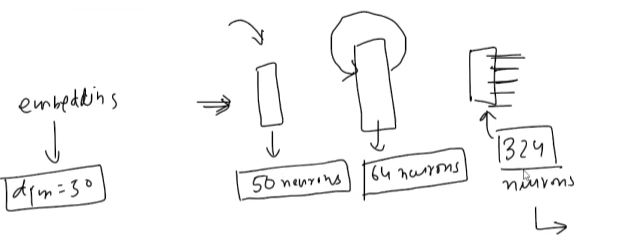

In [ ]:
# RNN Model

# Reason why we are not using sequential model : is because we need to define the embedding layer separately and then use it in the RNN layer.
# This is because the embedding layer needs to be initialized with the vocabulary size, which is not known until after the vocabulary is built.

class SimpleRNN(nn.Module):

  def __init__(self, vocab_size):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dim=50)  # Embedding layer to convert indices to Embedding vectors of dim 50, Embeding is created by using the vocab size.
    self.rnn = nn.RNN(50, 64, batch_first=True) # RNN layer with input size 50 and hidden size 64
    self.fc = nn.Linear(64, vocab_size)   # Fully connected layer to map RNN output to vocabulary size (i.e 324)
      # this is because among all 324 uniques word , the wording having most probability will be selected as the answer.

  def forward(self, question):
    embedded_question = self.embedding(question) # Convert indices to embedding vectors
    hidden, final = self.rnn(embedded_question) # Pass through RNN layer
    output = self.fc(final.squeeze(0))

    return output

In [ ]:
#debugging the model
x = nn.Embedding(324, embedding_dim=50)
y = nn.RNN(50, 64, batch_first=True)
z = nn.Linear(64, 324)

a = dataset[0][0].reshape(1,6)
print("shape of a:", a.shape)
b = x(a)
print("shape of b:", b.shape)
c, d = y(b)
print("shape of c:", c.shape)
print("shape of d:", d.shape)

e = z(d.squeeze(0))

print("shape of e:", e.shape)

shape of a: torch.Size([1, 6])
shape of b: torch.Size([1, 6, 50])
shape of c: torch.Size([1, 6, 64])
shape of d: torch.Size([1, 1, 64])
shape of e: torch.Size([1, 324])


In [18]:
learning_rate = 0.001
epochs = 20

In [19]:
model = SimpleRNN(len(vocab))

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

c:\ProgramData\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
# training loop

for epoch in range(epochs):

  total_loss = 0

  for question, answer in dataloader:

    optimizer.zero_grad()

    # forward pass
    output = model(question)

    # loss -> output shape (1,324) - (1)
    loss = criterion(output, answer[0])

    # gradients
    loss.backward()

    # update
    optimizer.step()

    total_loss = total_loss + loss.item()

  print(f"Epoch: {epoch+1}, Loss: {total_loss:4f}")

Epoch: 1, Loss: 524.863230
Epoch: 2, Loss: 458.499985
Epoch: 3, Loss: 380.698211
Epoch: 4, Loss: 317.922592
Epoch: 5, Loss: 266.009056
Epoch: 6, Loss: 218.195971
Epoch: 7, Loss: 174.296171
Epoch: 8, Loss: 136.124270
Epoch: 9, Loss: 104.992351
Epoch: 10, Loss: 80.782778
Epoch: 11, Loss: 62.652263
Epoch: 12, Loss: 48.734647
Epoch: 13, Loss: 38.597345
Epoch: 14, Loss: 31.179970
Epoch: 15, Loss: 25.812606
Epoch: 16, Loss: 21.258343
Epoch: 17, Loss: 17.790977
Epoch: 18, Loss: 15.047503
Epoch: 19, Loss: 12.969851
Epoch: 20, Loss: 11.254226


In [22]:
def predict(model, question, threshold=0.5):

  # convert question to numbers
  numerical_question = text_to_indices(question, vocab)

  # tensor
  question_tensor = torch.tensor(numerical_question).unsqueeze(0)

  # send to model
  output = model(question_tensor)

  # convert logits to probs
  probs = torch.nn.functional.softmax(output, dim=1)

  # find index of max prob
  value, index = torch.max(probs, dim=1)

  if value < threshold:
    print("I don't know")

  print(list(vocab.keys())[index])

In [23]:
predict(model, "What is the largest planet in our solar system?")

jupiter


In [24]:
list(vocab.keys())[7]

'paris'